# 0. IMPORTS

In [1]:
import pandas as pd
import inflection
import math 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import pickle
import random
import warnings
warnings.filterwarnings('ignore')

from boruta                import BorutaPy
from tabulate              import tabulate
from datetime              import date
from matplotlib            import gridspec
from IPython.display       import Image
from IPython.display       import HTML
from scipy                 import stats
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso 

import xgboost as xgb

## 0.1. Helper Functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )


        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
        
        # model
        m = model.fit( xtraining, ytraining )
        
        # prediction
        yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
        
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        
    return pd.DataFrame( {  'Model Name': model_name,
                            'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                            'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                            'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )

def mean_percentage_error(y,yhat):
    return np.mean((y-yhat)/y)

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )    

    
def cramer_v(x,y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r,k = cm.shape
    
    
    chi2 = stats.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2/n - ((k-1)*(r-1)/(n-1)))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr) / (min(kcorr-1, rcorr-1)))


def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
   # for pandas to display the complete dataframe, with no restriction on the number of columns to be displayed, I can change the following option:
    pd.set_option('max_columns', None, "max_rows", 50)
    #pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()  


In [3]:
jupyter_settings()

### 0.2. Loading Data 

In [4]:
# Low_memory set to False reads the csv file in chunks. Avoid getting an error
df_sales_raw = pd.read_csv('rossmann-store-sales/train.csv', low_memory = False) 
df_store_raw = pd.read_csv ('rossmann-store-sales/store.csv', low_memory = False)

# merge
df_raw = pd.merge (df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DATA DESCRIPTION

1) Understanding the business; How challenging is the problem I am dealing with; How much data we have to work with (Maybe my computer is not capable of processing a certain amount of data)

2) Understanding our variables: numerical, categorical, datetime

3) Missing data


In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
# df1.columns

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
             'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 
             'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

#snakecase = lambda x: x.lower()
snakecase = lambda x: inflection.underscore(x)

cols_new = list((map(snakecase,cols_old)))

# rename
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [7]:
print('Number of rows: {}'. format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3. Data Types

In [8]:
# changing the date type from object to datetime
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

1) Understand why there are Not Available (NA) data; Always start with this approach.

2) Remove all the lines with Not Available (NA) data. Disadvantage: Information is lost

3) Use a ML algorithm to fill in the Not Available (NA) data, or use mean/median



### 1.5.1. Competition Distance   
For stores that do not have Competition Distance information, I will assume: 

- There is no competition;

- The closest competitor might be too far to compute. 

Filling these column with numbers way higher than the current maximum distance is a good way to represent the 2 hypothesis assumed previously.

In [10]:
# maximum competition distance in the dataset
print('The maximum distance in the dataset is {} meters\n'. format(df1['competition_distance'].max()))

# stores with no Competition distance Data
print('Stores missing values:')
print(df1[df1['competition_distance'].isna()]['store'].unique())

# filling up with data
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

# df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if pd.isna(x) else x)

# for i in range(len(df1)):
#     if pd.isna(df1.loc[i,'competition_distance']) == True:
#         df1.loc[i,'competition_distance'] = 200000

# checking if changes were applied

print("\nThere are " + str(df1["competition_distance"].isna().sum()) + " missing value(s).")

The maximum distance in the dataset is 75860.0 meters

Stores missing values:
[291 622 879]

There are 0 missing value(s).


### 1.5.2. Competition Open Since Month    
Reasons for lack of data:
- There is no competition;
- Competition was opened but not recorded.

For stores with no Competition Open Since Month available, I am considering that the date the competition was open is the same date the sale ocurred.  The reason I am making this assumption is because competition stores might have a significant impact in Rossmann Stores' sales. And filling up using this method have little effect on sales for the lines that initially were NA.

In [11]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month 
                                                if math.isnan(x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis = 1)

### 1.5.3. Competition Open Since Year

In [12]:
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year 
                                                if math.isnan(x['competition_open_since_year'])
                                                else x['competition_open_since_year'], axis = 1)

### 1.5.4. Promo2 Since Week

In [13]:
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week 
                                     if math.isnan(x['promo2_since_week'])
                                     else x['promo2_since_week'], axis = 1)

### 1.5.5. Promo2 Since Year               

In [14]:
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year 
                                     if math.isnan(x['promo2_since_year'])
                                     else x['promo2_since_year'], axis = 1)

### 1.5.6. Promo Interval
Replacing N/A with 0.

In [15]:
month_map = {1: 'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

# if the month of the row date is the start month of promo2, 'is_promo' == 1, if not 'is_promo' == 0
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 
                                                                      1 if x['month_map'] in x['promo_interval'].split(',') else
                                                                      0, axis = 1 )

## 1.6. Change Types

Replacing NA may change the variable types, so I will check again and change the type if needed.

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical


### Statistical Metrics:

   **Central tendency**: average, median
   
   **Dispersion**: variance, standard deviation, amplitude
   
   *Skew*: a distortion or asymmetry that deviates from the symmetrical bell curve
   
   *Kurtosis*: a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. Data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers.
   
These metrics gives us an idea of how our data is behaving and bring up potential errors. Example: What if I observe a negative value for sales? This can be an error I should verify.


In [18]:
num_attributes = df1.select_dtypes( include = ('int64','float64'))
cat_attributes = df1.select_dtypes( exclude = ('int64','float64','datetime64[ns]'))
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
632406,987,4,6170,835,1,0,0,1690.0,6,2007,0,50,2013,0
220868,99,3,6317,512,1,1,0,2030.0,11,2003,1,22,2012,0


### 1.7.1. Numerical Attributes


In [19]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

# concatenate
n = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
n.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

In [20]:
n

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


#### Fixing Competition Open Since Year potential typo mistake

In [21]:
print(sorted(set(df1['competition_open_since_year'])), end ='\n\n')

print(df1[df1['competition_open_since_year'] == 1900]['store'].unique())



# store 815 is presenting inconsistent values (might be a typo), 
# so I will replace competition_open_since_year with 1990 

df1['competition_open_since_year'] = df1.apply(lambda x: 1990 if x['store'] == 815 else x['competition_open_since_year'], axis = 1)

# for i in range(len(df1)):
#     if df1.loc[i, 'store'] == 815:
#         df1.loc[i,'competition_open_since_year'] = 1990

[1900, 1961, 1990, 1994, 1995, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]

[815]


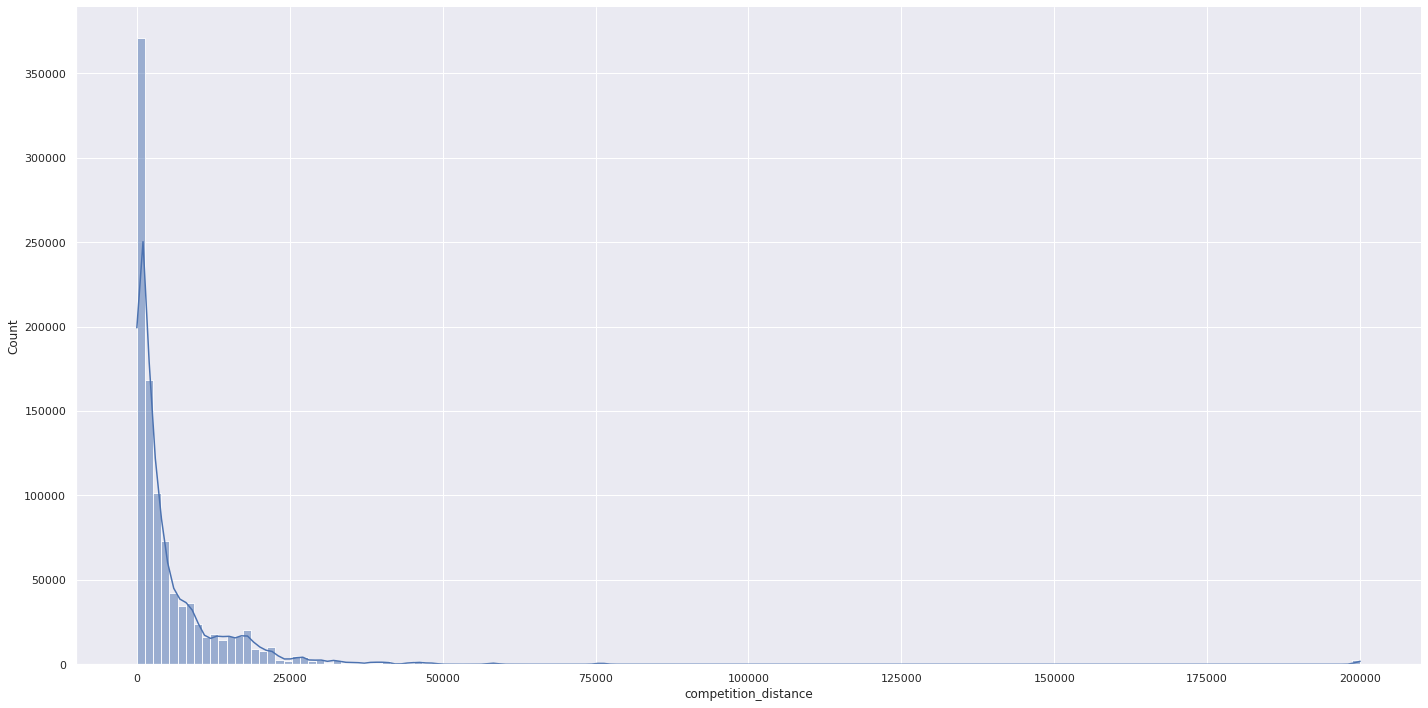

In [22]:
# sns.histplot (df1 ['sales'], kde=True, stat="density", linewidth=0, binwidth=1500)
sns.displot (df1 ['competition_distance'], kde=True, bins = 150, height = 10, aspect = 2)
plt.show()

### 1.7.2. Categorical Attributes


In [23]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

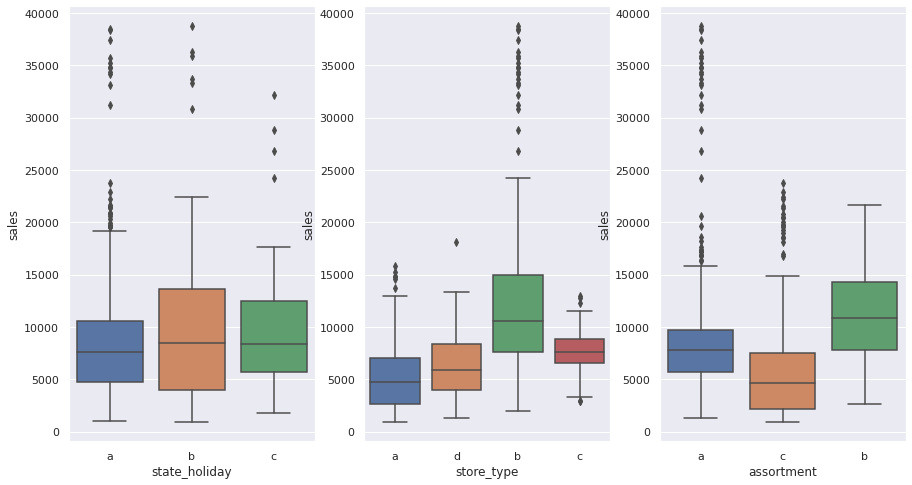

In [24]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]

sns.set(rc = {'figure.figsize':(15,8)})
plt.subplot(1,3,1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot( x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot( x='assortment', y='sales', data=aux1)

plt.show()

# 2.0. FEATURE ENGINEERING

The purpose of Feature Engineering is to have the variables availble to study during the Exploratory Data Analysis (EDA). 

How to create hypotheses? Play with the variables that influence the main event. Consider an Hypothesis as a bet. Brainstorm with the business team what would levarage our sales.

The goal is to understand how the attributes affect our main event (sales).

*Example*: Stores with bigger assortment are more likely to sell more. 


In [25]:
df2 = df1.copy()

## 2.1. Hypotheses Mind Map 

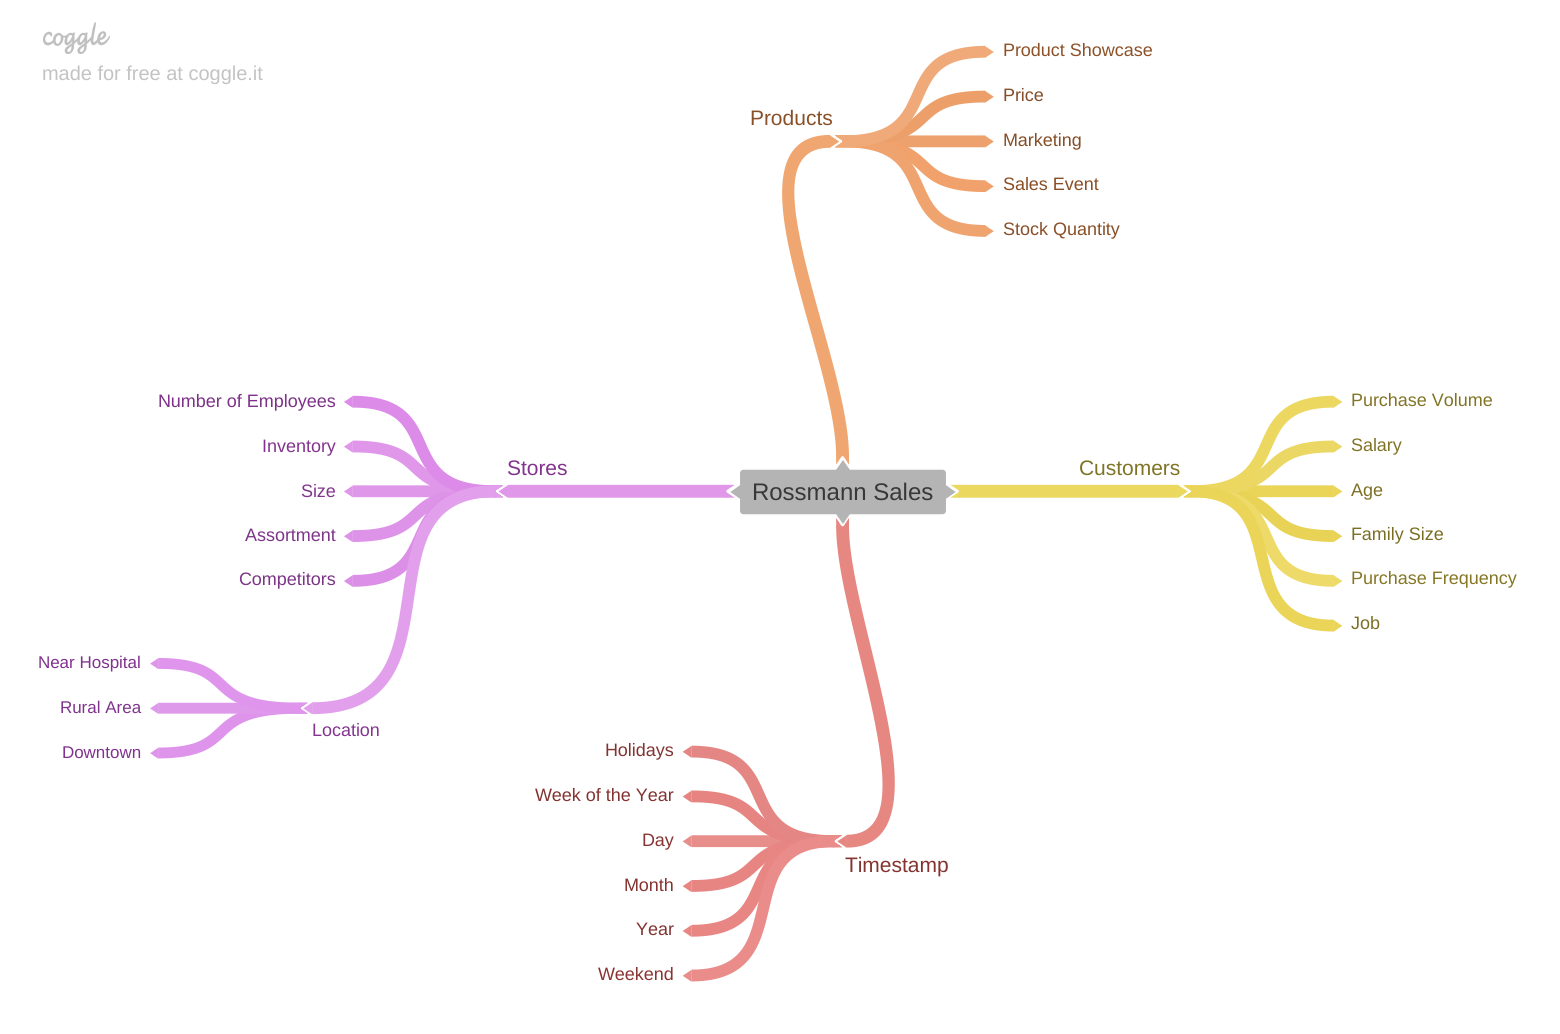

In [26]:
Image('Images/MindMap_Hypothesis.png')

## 2.2. Hyphotheses
Start working with hypothesis that have data available.

**H1.** Stores with a bigger product assortment are more likely to sell more daily

**H2.** Stores with closer competitors are more likely to sell less

**H3.** Stores with longer-standing competitors are more likely sell more

**H4.** Products on sales during a long period of time are more likely to sell more daily

**H5.** Stores with more extended promotions are more likely to sell more

**H6.** Sales are more likely to increase during holiday season (Christmas)

**H7.** Stores are more likely to sell more over the years

**H8.** Stores are more likely to sell more in the second half of the year

**H9.** Stores are more likely to sell more after the 10th day of each month

**H10.** Stores are more likely to sell less on weekends

**H11.** Stores are more likely to sell less during school holidays

## 2.3. Feature Engineering


In [27]:
# year
df2 ['year'] = df2['date'].dt.year

# month
df2 ['month'] = df2['date'].dt.month

# day
df2 ['day'] = df2['date'].dt.day

# week of year
df2 ['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2 ['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])).apply( lambda x: (x.days)/30).astype(int)



# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )).apply(lambda x: (x.days)/7  ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' 
                                                  else 'easter_holiday' if  x=='b'  
                                                  else 'christmas' if x == 'c'
                                                  else 'regular_day')

In [28]:
df2.sample(5).T

,565741,149307,56334,438801,848868
store,107,1013,585,277,24
day_of_week,7,5,4,2,5
date,2014-02-09 00:00:00,2015-03-20 00:00:00,2015-06-11 00:00:00,2014-06-03 00:00:00,2013-05-31 00:00:00
sales,0,4031,4027,7568,15577
customers,0,436,694,571,1244
open,0,1,1,1,1
promo,0,1,0,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,0
store_type,a,a,d,d,a


# 3.0. FILTERED VARIABLES

Filtering variables according to the business model.

In [29]:
df3 = df2.copy()

## 3.1. Filtered Rows

**open**: Store closed does not help our model. Store closed = no sales.


In [30]:
# df3 = df3.loc[df3['open'] == 1]
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtered Columns

**customers**: I do not have the number of customers at the moment I am predicting each store sales.

**open**: After filtering closed stores, all column will have value = 1.

**promo_interval** and **month_map**: helper columns used to create other columns


In [31]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

In [32]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. EXPLORATORY DATA ANALYSIS (EDA)

How do our variables impact our target variable? Exploring the data helps to find insights and better understand the impact of variables on model learning.

Validating hypothesis created with the Hypotheses Mind Map

Creating Insights


In [33]:
df4 = df3.copy()

Updating the descriptive values after filtering and cleaning the data:

In [34]:
num_attributes = df4.select_dtypes( include = ('int64','float64'))
cat_attributes = df4.select_dtypes( exclude = ('int64','float64','datetime64[ns]'))


# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

# concatenate
n = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
n.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
n

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.421374,558.0,321.730671,0.000426,-1.198836
1,day_of_week,1.0,7.0,6.0,3.520350,3.0,1.723711,0.019310,-1.259347
2,sales,46.0,41551.0,41505.0,6955.959134,6369.0,3103.813677,1.594929,4.854027
3,promo,0.0,1.0,1.0,0.446356,0.0,0.497114,0.215824,-1.953425
4,school_holiday,0.0,1.0,1.0,0.193578,0.0,0.395102,1.551109,0.405939
5,competition_distance,20.0,200000.0,199980.0,5961.827515,2330.0,12592.173650,10.134908,145.288658
6,competition_open_since_month,1.0,12.0,11.0,6.787355,7.0,3.309915,-0.048451,-1.231875
7,competition_open_since_year,1961.0,2015.0,54.0,2010.397402,2012.0,4.648819,-2.225574,12.778412
8,promo2,0.0,1.0,1.0,0.498670,0.0,0.499998,0.005320,-1.999976
9,promo2_since_week,1.0,52.0,51.0,23.629083,22.0,14.288306,0.170399,-1.194815


## 4.1. Univariate Analysis


### 4.1.1. Response Variable


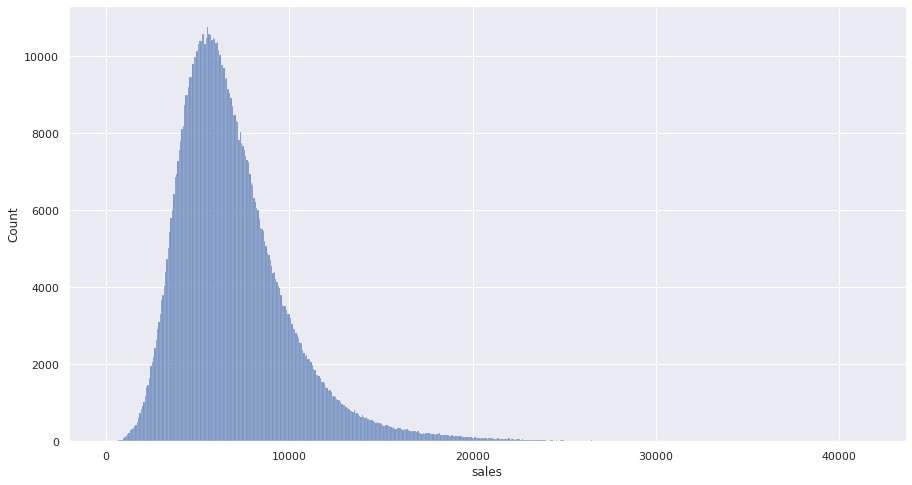

In [35]:
sns.histplot(df4['sales'])
plt.show()

### 4.1.2. Numerical Variable


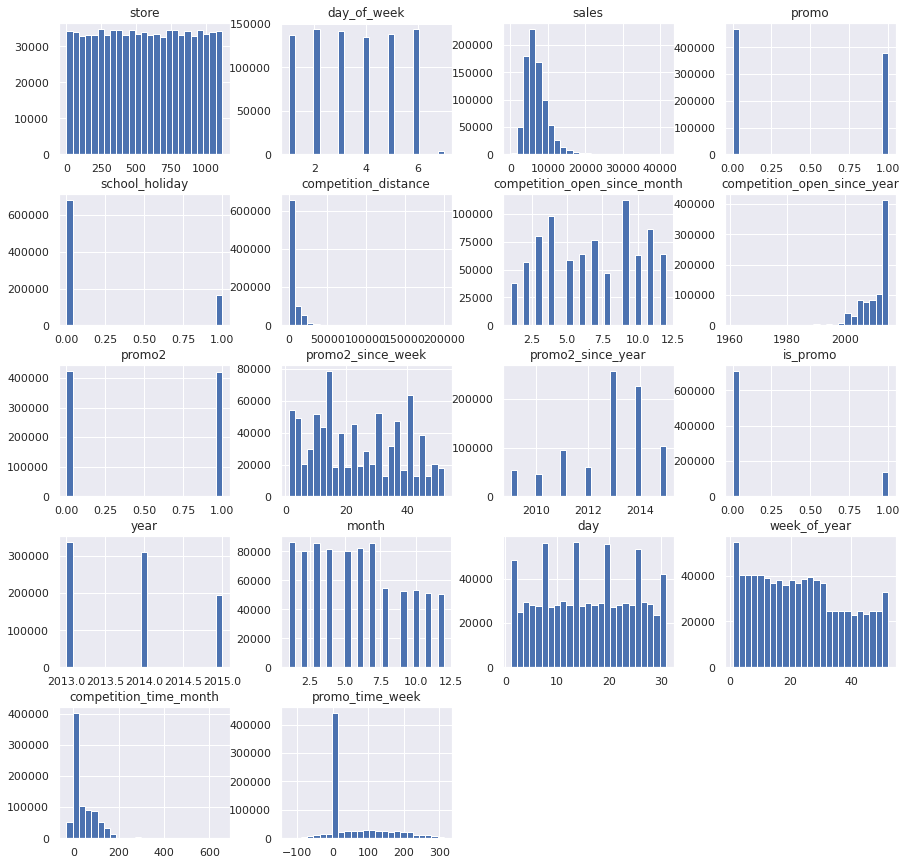

In [36]:
sns.set(rc = {'figure.figsize':(15,15)})
num_attributes.hist(bins = 25);

Analysis Summary:
- None of variables are normally distributed
- There is not much difference in sales number on the six days of the week that stores are open 
- More sales occured without promotion 
- There is a certain behaviour on when competitors prefer to open their stores (Peak: September)
- Competitors are mostly located in a small distance from Rossmann stores
- There is an increase of competitors in the last few years
- After first promo was applied, half of sales happened with second promo


### 4.1.3. Categorical Variable


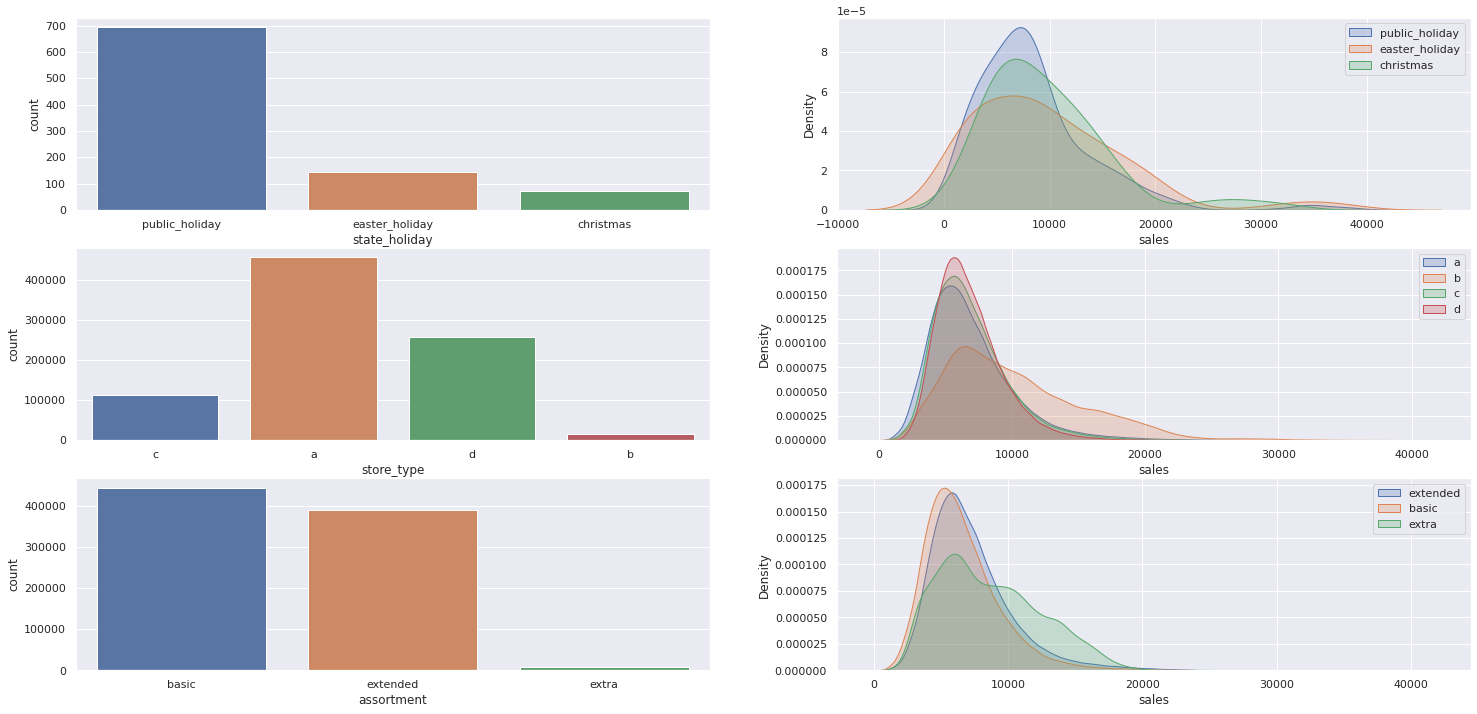

In [37]:
plt.figure(figsize=(25,12))

# state_holiday
plt.subplot(3,2,1)
sns.countplot(data = df4[df4['state_holiday'] != 'regular_day'],x = 'state_holiday')

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True)
plt.legend()

# store_type
plt.subplot(3,2,3)
sns.countplot(data = df4, x = 'store_type')

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(data = df4, x = 'assortment')

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade=True)
plt.legend()

plt.show()

## 4.2. Bivariate Analysis


### H1. Stores with a bigger product assortment are more likely to sell more daily

**True: stores with a bigger product assortment are more likely to sell more**

In [38]:
# print(df4[df4['assortment'] == 'extra'].shape[0])
# print(df4[df4['assortment'] == 'basic'].shape[0])
# print(df4[df4['assortment'] == 'extended'].shape[0])

df4[['assortment','sales']].groupby('assortment').count()

,sales
assortment,
basic,444875
extended,391254
extra,8209


Comparing the average sales and investigating the sales performance over time for each store assortment type.

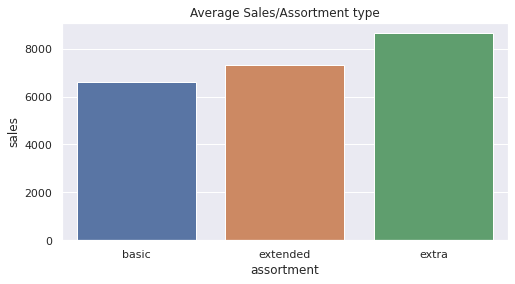

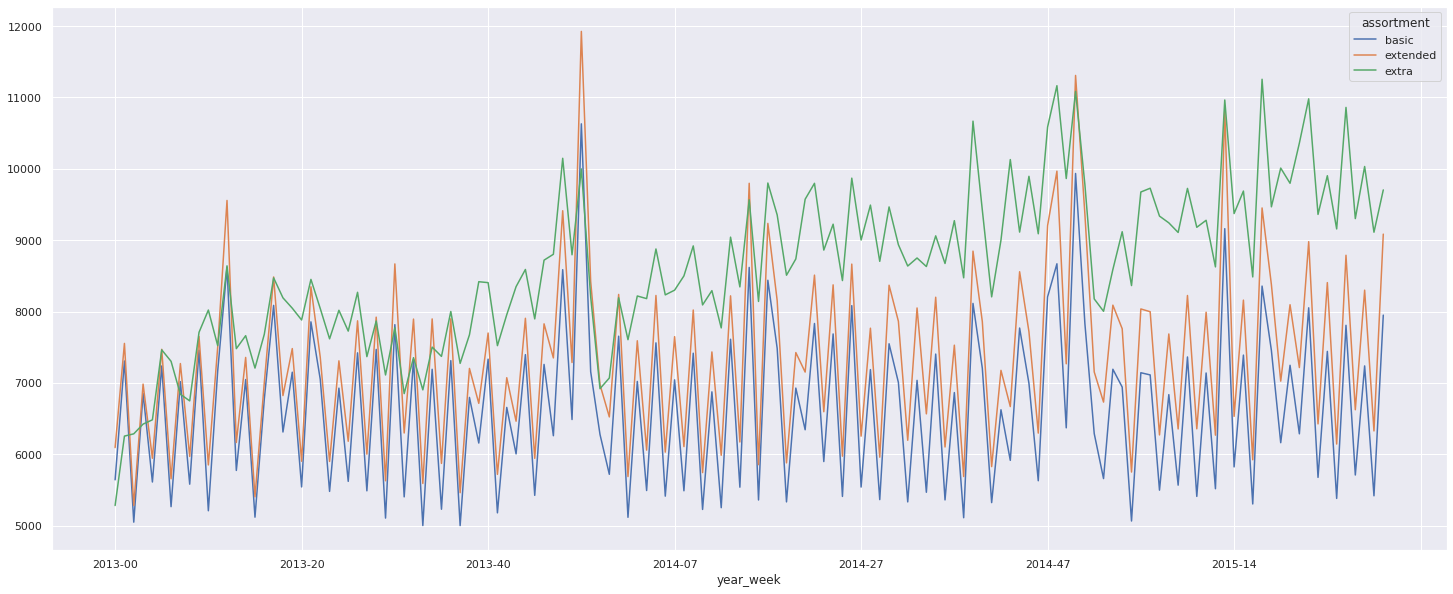

In [39]:
plt.figure(figsize=(8,4))
aux1 = df4[['assortment','sales']].groupby('assortment').mean().reset_index()
sns.barplot(data = aux1, x='assortment', y = 'sales').set(title='Average Sales/Assortment type')
plt.savefig('Images/H1.png')

aux2 = df4[['assortment','sales','year_week']].groupby(['assortment','year_week']).mean().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment',values = 'sales').plot(figsize=(25,10))
plt.savefig('Images/H1_1.png')

plt.show()

### H2. Stores with closer competitors are more likely to sell less

**False: The distance from competitors does not influence store sales.**

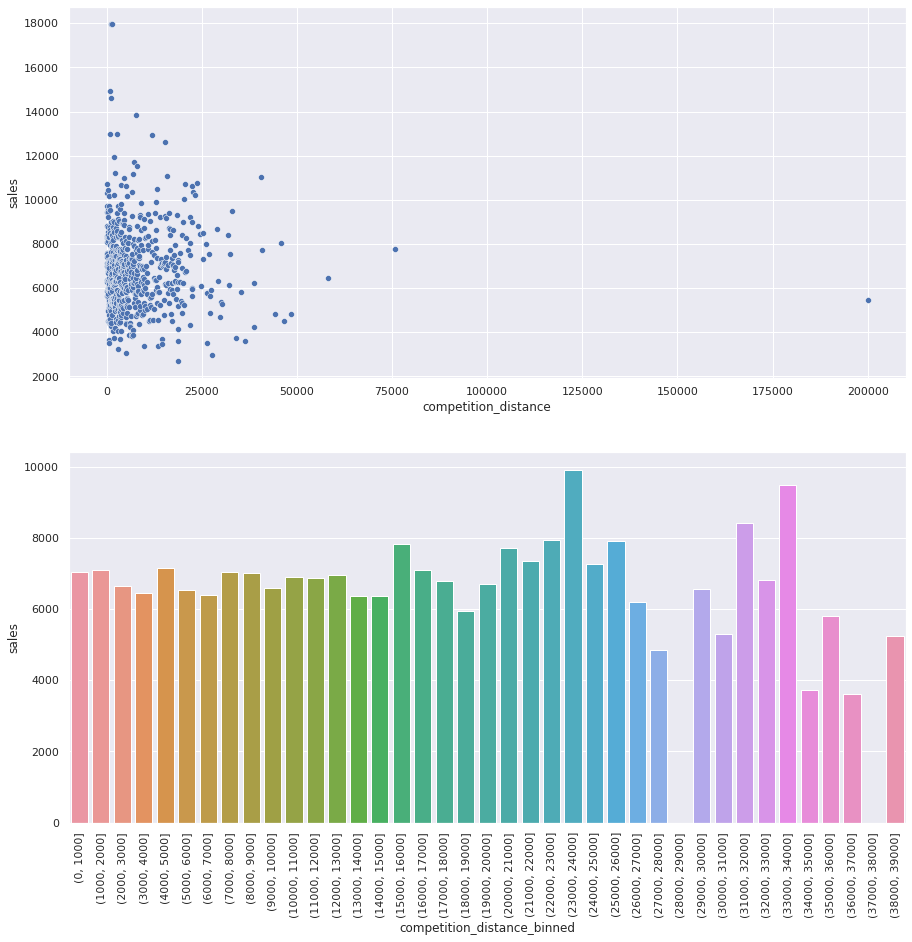

In [40]:
plt.subplot(2,1,1)
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
sns.scatterplot( x = 'competition_distance', y='sales', data=aux1);
plt.savefig('Images/H2.png')


plt.subplot(2,1,2)
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
bins = list( np.arange(0,40000,1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').mean().reset_index()

sns.barplot( x = 'competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90);
plt.savefig('Images/H2_2.png')


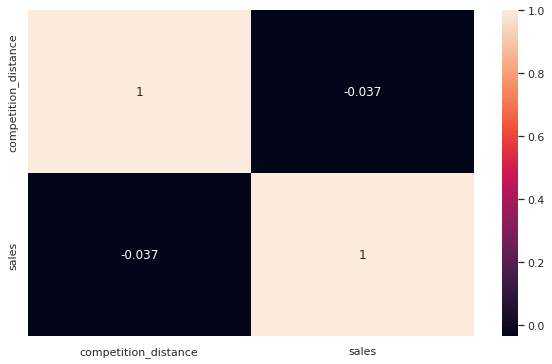

In [41]:
plt.figure(figsize=(10,6))
sns.heatmap( aux1.corr(method = 'pearson'), annot = True);

### H3.  Stores with longer-standing competitors are more likely to sell more

**False: It is not possible to conclude that stores with longer-standing competitors are more likely to sell more.**

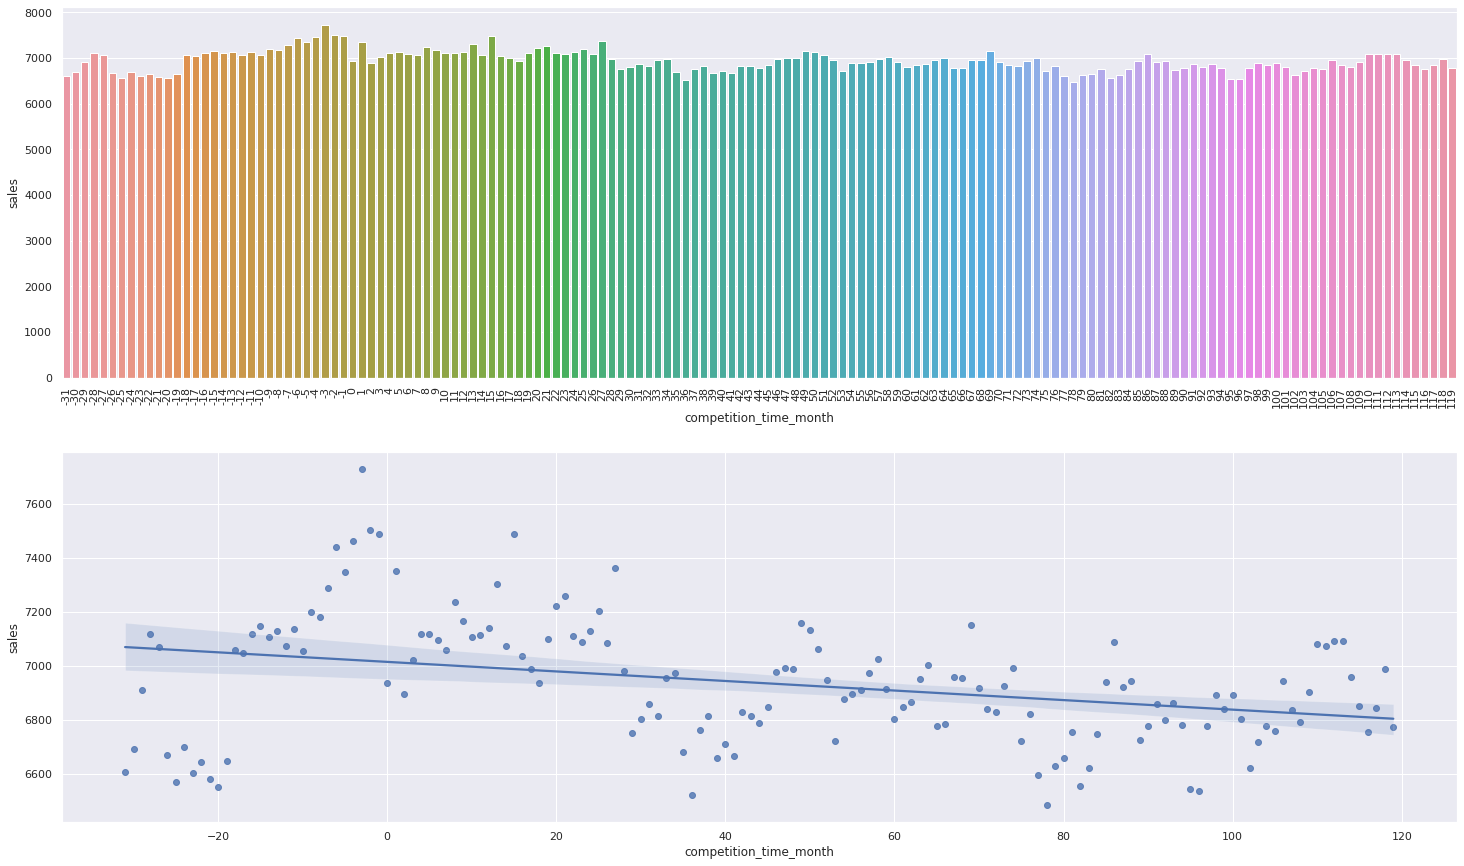

In [42]:
plt.figure(figsize=(25,15))
plt.subplot( 2,1,1 )
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').mean().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 )]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2)
plt.xticks(rotation=90);

plt.subplot( 2,1,2 )
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);


Negative values for competition time (in months) mean that are sales were recorded before the nearest competitor opened.

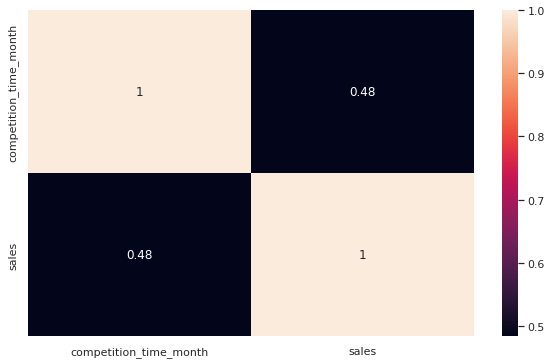

In [43]:
plt.figure(figsize=(10,6))
sns.heatmap( aux1.corr (method='pearson'), annot = True);

### H4. Products on sales during a long period of time are more likely to sell more daily

**True: After aplying promo2, stores sales average slightly increased over time.**

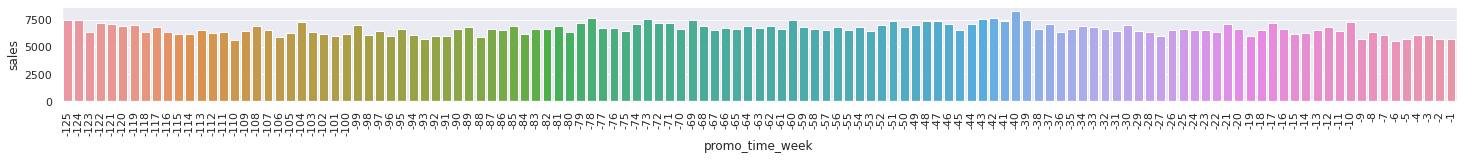

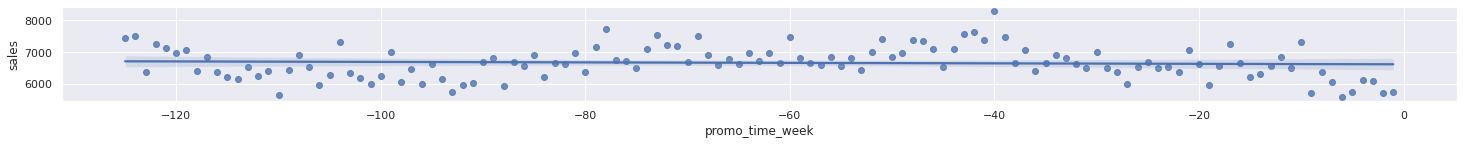

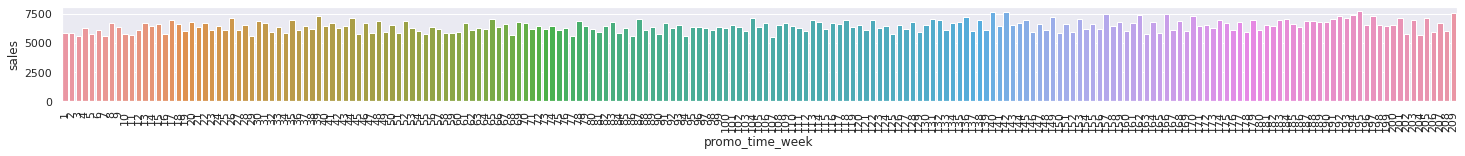

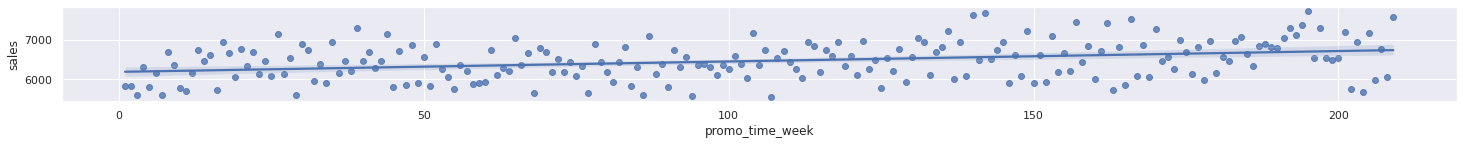

In [44]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').mean().reset_index()

grid = plt.GridSpec( 4,1 )

plt.figure(figsize=(25,8))
plt.subplot( grid[0,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promotion
sns.barplot(data=aux3, x='promo_time_week', y='sales')
plt.xticks(rotation=90);

plt.figure(figsize=(25,8))
plt.subplot( grid[1,0] )
sns.regplot( x = 'promo_time_week', y='sales', data=aux3)


plt.figure(figsize=(25,8))
plt.subplot( grid[2,0] )
aux2 = aux1[(aux1['promo_time_week'] > 0) & (aux1['promo_time_week'] <210)] # extended promotion
sns.barplot(data=aux2, x='promo_time_week', y='sales')
plt.xticks(rotation=90);

plt.figure(figsize=(25,8))
plt.subplot( grid[3,0] )
sns.regplot( x = 'promo_time_week', y='sales', data=aux2);

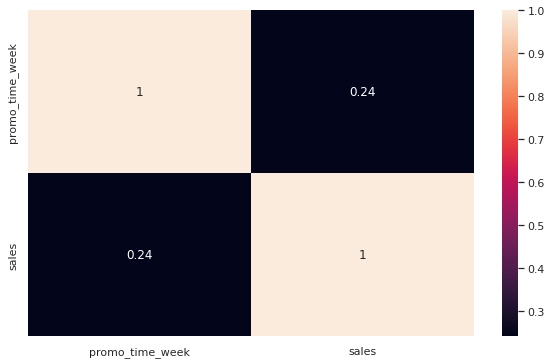

In [45]:
plt.figure(figsize=(10,6))
sns.heatmap(aux1.corr(method='pearson'), annot=True);

Before extending promo2, stores sales were constant on average. After aplying promo2, stores sales average slightly increased over time.

### H5. Stores with more extended promotions are more likely to sell more

**False: Stores that applied promo2 followed by promo1 performed worse on average when compared to stores that applied only the first promotion.**

In [46]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).mean().reset_index().sort_values(by='sales')

,promo,promo2,sales
1,0,1,5529.566684
0,0,0,6328.187633
3,1,1,7836.672987
2,1,0,8618.452062


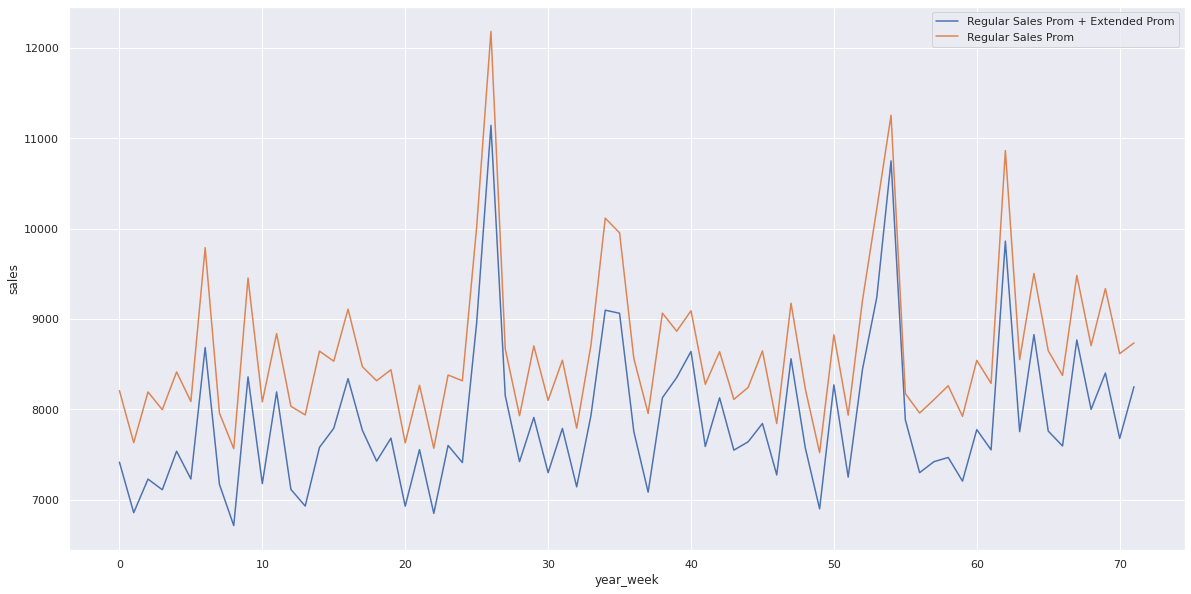

In [47]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').mean().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux2.plot(ax = ax, figsize=(20,10),xlabel='year_week',ylabel='sales')

ax.legend( labels = ['Regular Sales Prom + Extended Prom', 'Regular Sales Prom']);

plt.savefig('Images/H3.png')

Historically, following this approach do not work in terms of generating more sales.

### H6. Sales are more likely to increase the during holiday season (Christmas)

**True: On average, Christmas holiday, along with Easter, are holidays with higher sales.**

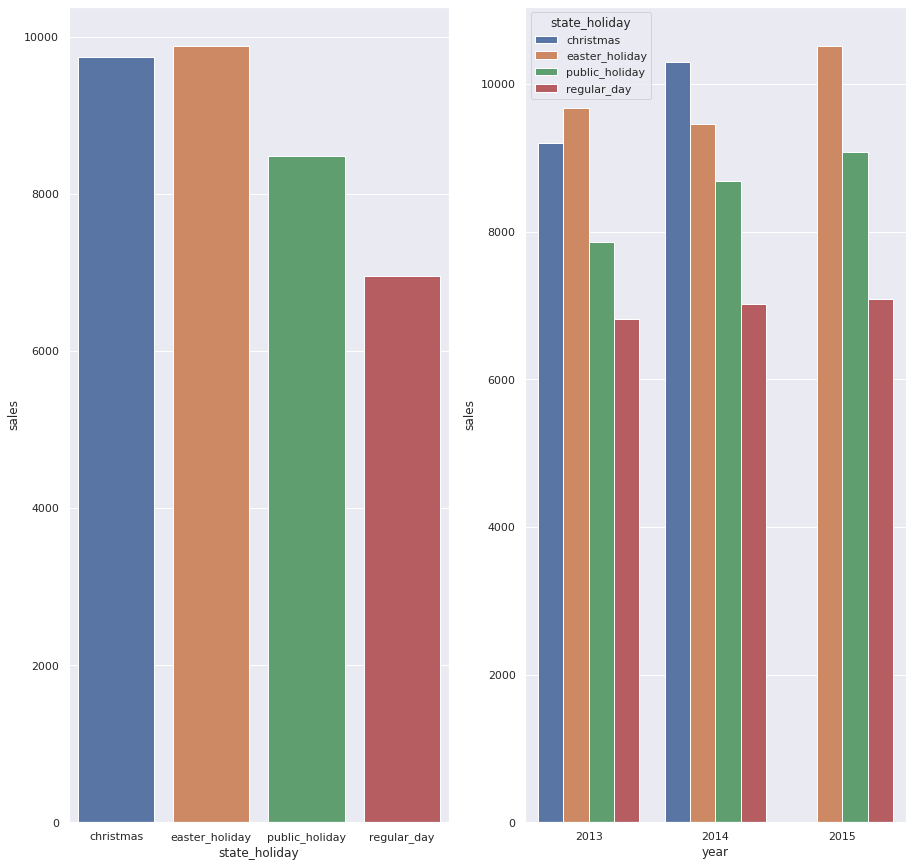

In [48]:
plt.subplot(1,2,1)
aux1 = df4[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1,2,2)
aux2 = df4[['year','state_holiday', 'sales']].groupby(['year','state_holiday']).mean().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2);


There is no information about Christmas sales on 2015 because the last day recorded in the dataset is 07/31/2015.

### H7. Stores are more likely to sell more over the years

**Not enough information to get to a conclusion.**

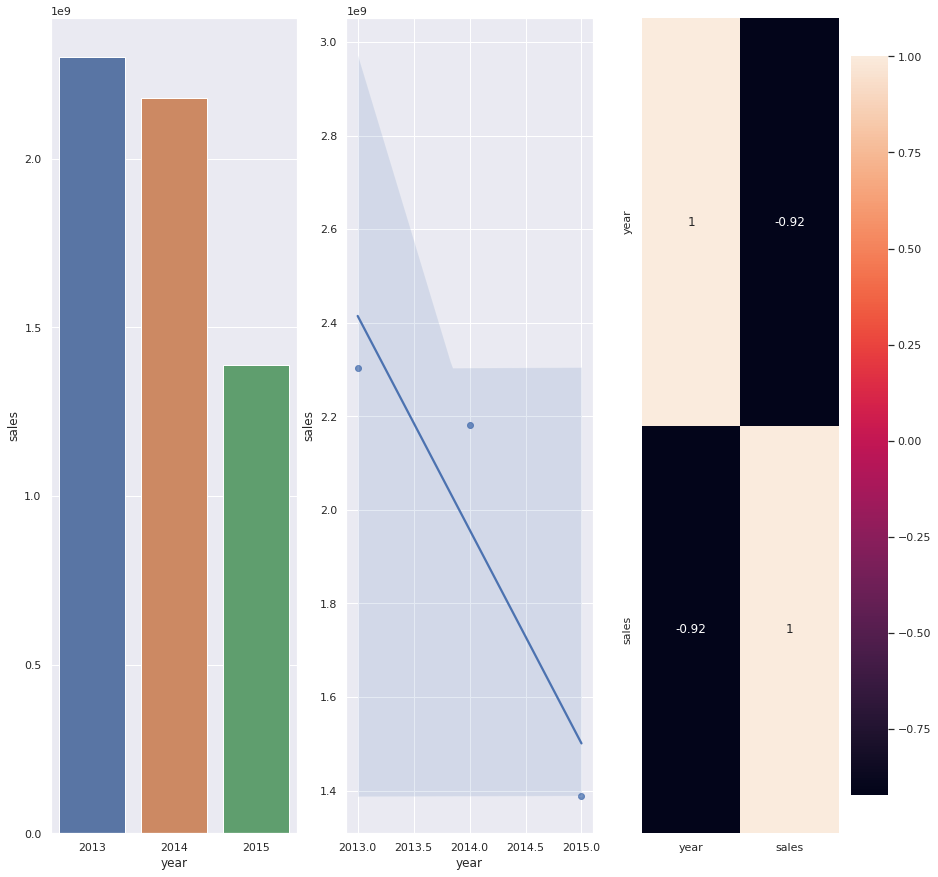

In [49]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot(x='year', y='sales', data = aux1)

plt.subplot( 1, 3, 2)
sns.regplot(x='year', y='sales', data = aux1)

plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

There are only 2 years of data fully available (partial data from 2015). It is possible to say that the sum of sales reduced from 2013 to 2014. However; to get to a conclusion, sales metrics should be monitored over a longer period of time.

### H8. Stores are more likely to sell more in the second half of the year

**True: The month of December performs well in terms of sales, which increases the second half of the year's average.** 

However; months like September and October do not perform so well.

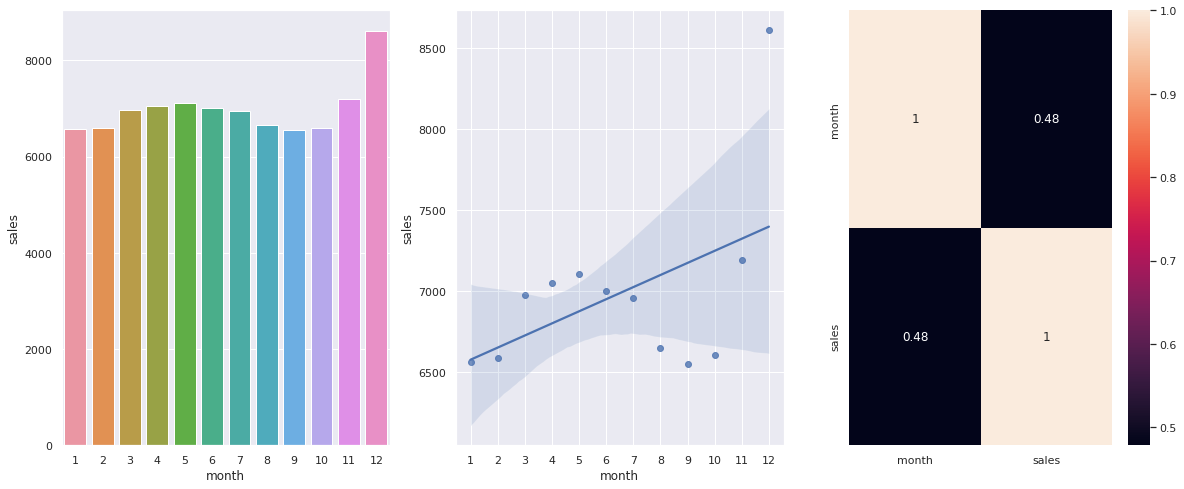

In [50]:
aux1 = df4[['month','sales']].groupby('month').mean().reset_index()

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.xlabel

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()

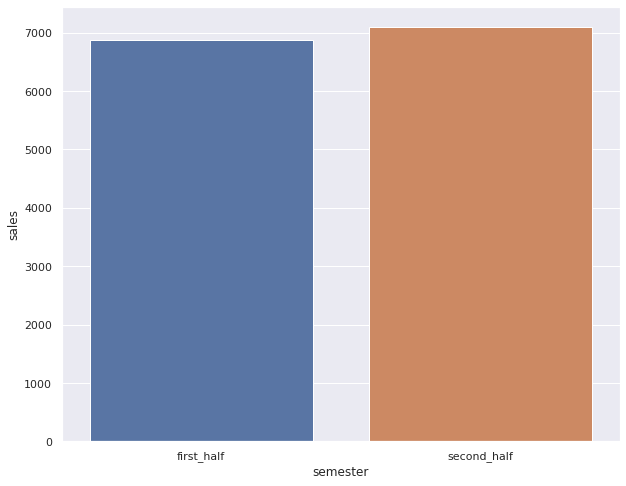

In [51]:
aux1['semester'] = aux1['month'].apply(lambda x: 'first_half' if 
                                       x in [1,2,3,4,5,6] else 'second_half')
aux2 = aux1[['semester','sales']].groupby('semester').mean().reset_index()
plt.figure(figsize=(10,8))
sns.barplot(x='semester', y='sales', data=aux2);

### H9. Stores are more likely to sell more after the 10th day of each month

**True: On average, stores sell slightly more after the 10th day of each month.**

Stores sales constantly decrease after the first day of the month until the 10th day. After the 11th day, values fluctuate until reaching the peak at the 30th day of the month.

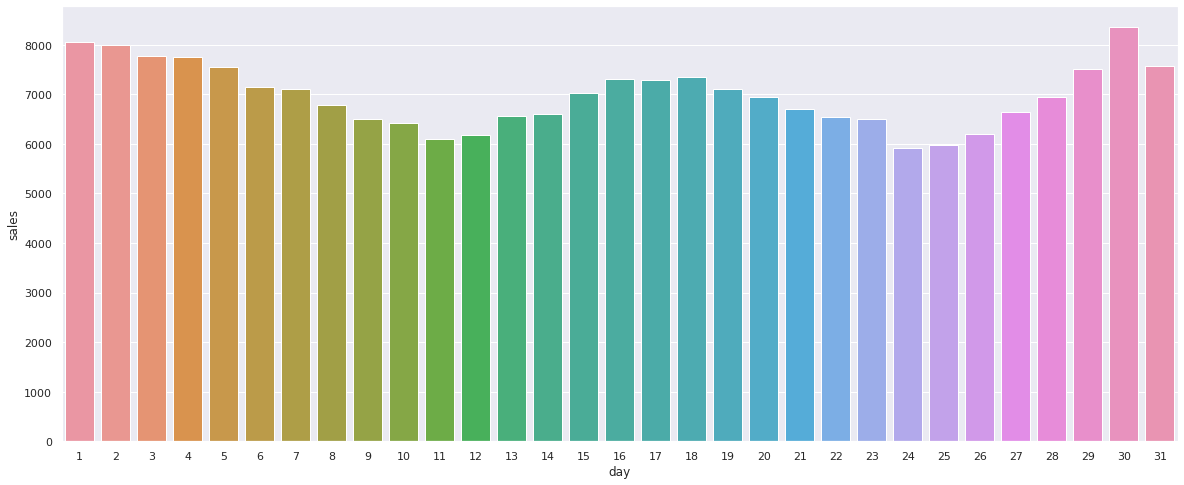

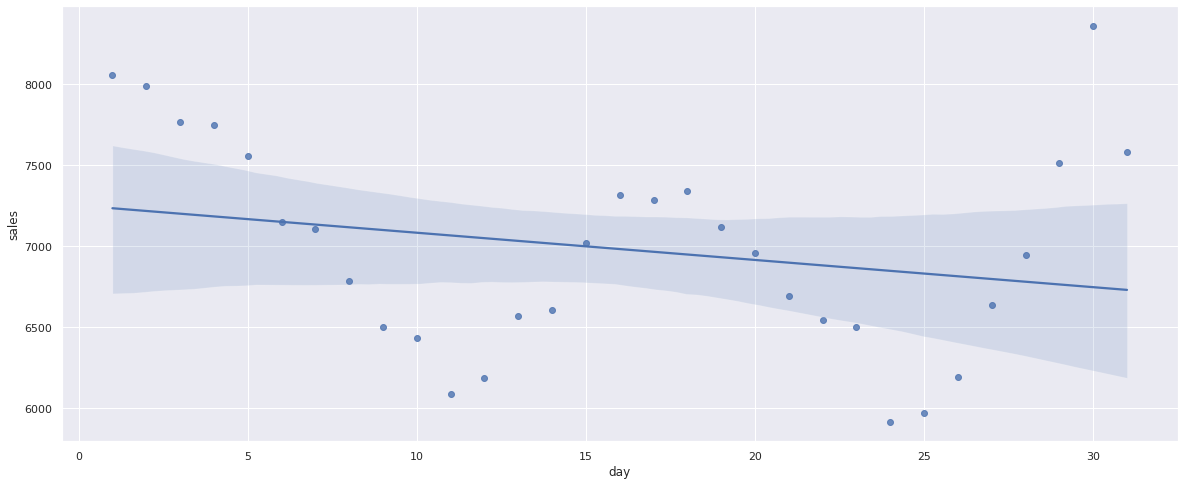

In [52]:
aux1 = df4[['day', 'sales']].groupby('day').mean().reset_index()

plt.figure(figsize=(20,8))
sns.barplot(x='day', y='sales', data = aux1);

plt.figure(figsize=(20,8))
sns.regplot(x='day', y='sales', data = aux1);

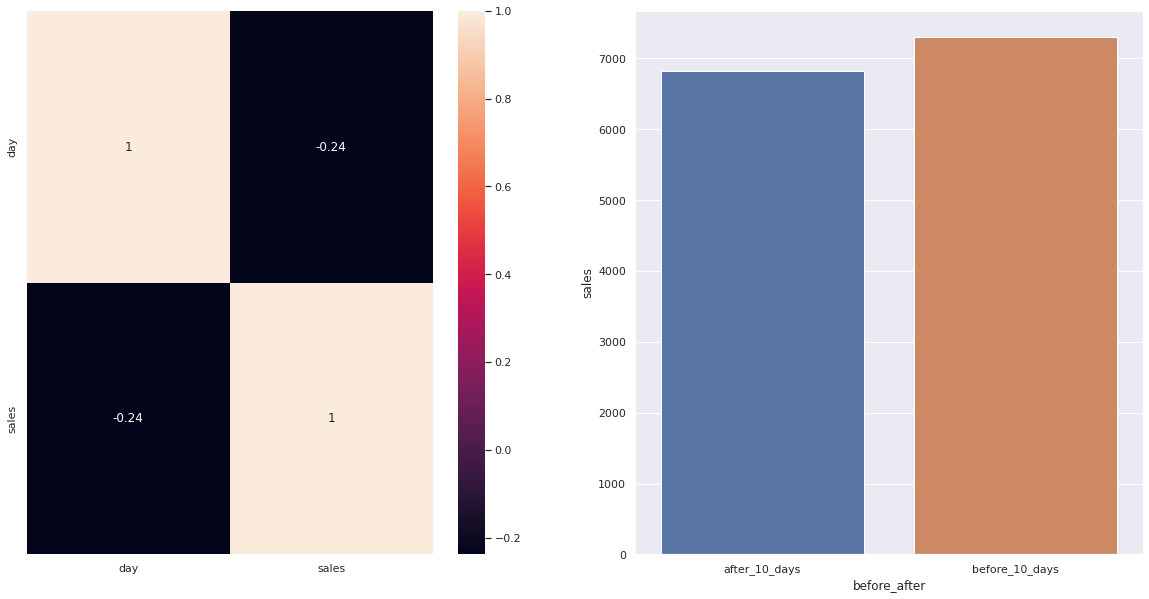

In [53]:
plt.figure(figsize=(20,10))
plt.subplot( 1, 2, 1)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

plt.subplot( 1, 2, 2)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').mean().reset_index()
sns.barplot(x='before_after', y='sales', data = aux2);



### H10. Stores are more likely to sell less on weekends

**True: Considering the total amount from all stores, Saturday and Sunday fall behind when compared with weekday sales.**

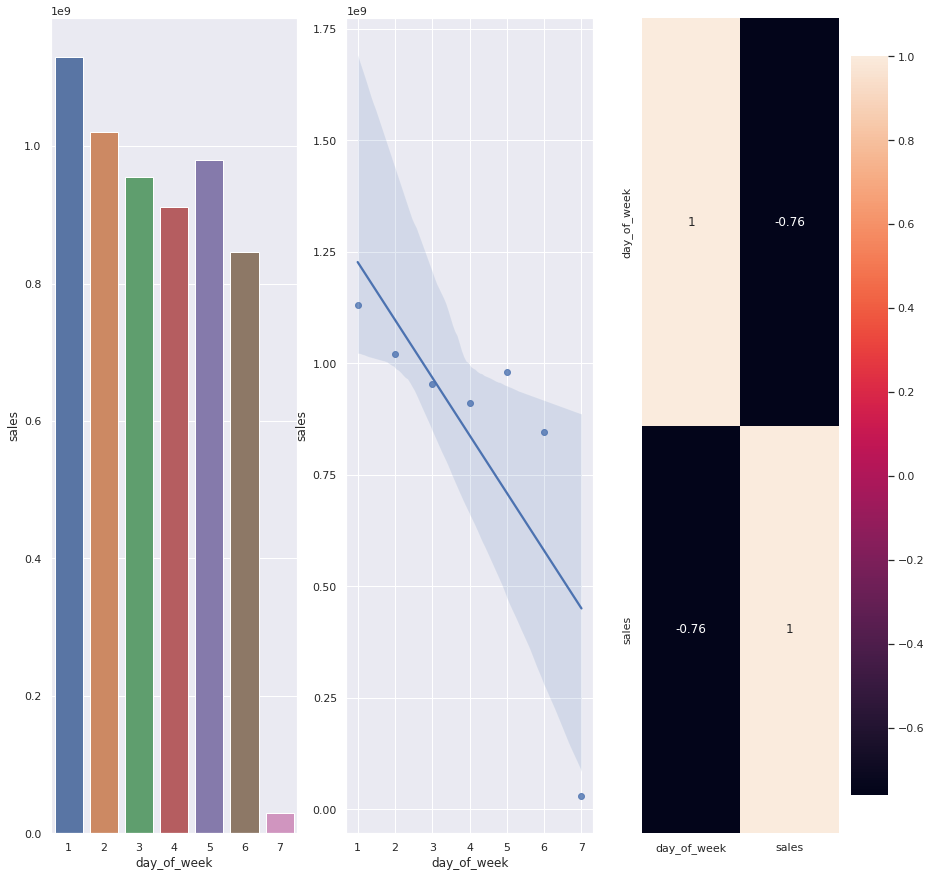

In [54]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data = aux1)

plt.subplot( 1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data = aux1)

plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot = True);

### H11. Stores are more likely to sell less during school holidays

**False: On average, stores sell more on school holidays**

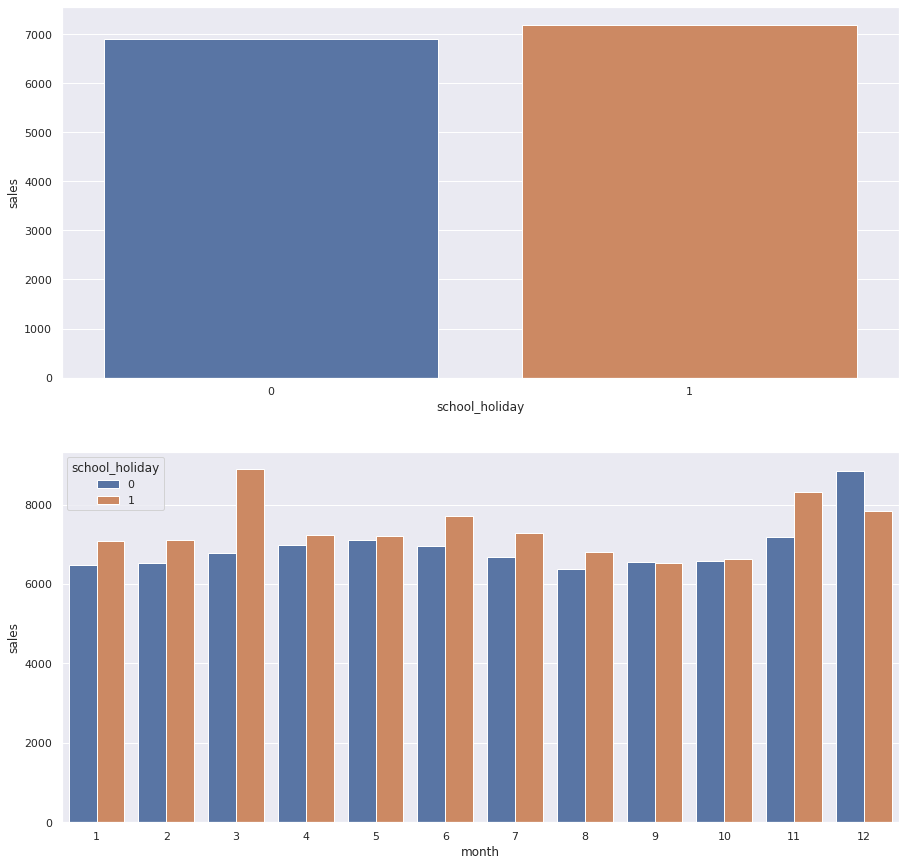

In [55]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').mean().reset_index()
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).mean().reset_index()
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);



## Hypothesis Summary 


In [56]:
table = [['Hypotheses', 'Conclusion', 'Relevance'],
        ['H1 - stores with a bigger product assortment are more likely to sell more daily', 'true','medium'],
        ['H2 - stores with closer competitors are more likely to sell less', 'false','low'],
        ['H3 - stores with longer-standing competitors are more likely sell more','false','medium'],
        ['H4 - products on sales during a long period of time are more likely to sell more daily', 'true','low'],
        ['H5 - stores with more extended promotions are more likely to sell more', 'false', 'medium'],
        ['H6 - sales are more likely to increase the during holiday season (Christmas)','true', 'high'],
        ['H7 - stores are more likely to sell more over the years', 'inconclusive', 'high*'],
        ['H8 - stores are more likely to sell more in the second half of the year','true','medium'],
        ['H9 - stores are more likely to sell more after the 10th day of each month', 'true', 'medium'],
        ['H10 - stores are more likely to sell less on weekends', 'true', 'high'],
        ['H11 - stores are more likely to sell less during school holidays','false','medium']     
        ]

print(tabulate(table, headers='firstrow'))
print("\n*although the H7 was inconclusive, the variable 'year' is considered relevant when analyizing the sales over time.")

Hypotheses                                                                              Conclusion    Relevance
--------------------------------------------------------------------------------------  ------------  -----------
H1 - stores with a bigger product assortment are more likely to sell more daily         true          medium
H2 - stores with closer competitors are more likely to sell less                        false         low
H3 - stores with longer-standing competitors are more likely sell more                  false         medium
H4 - products on sales during a long period of time are more likely to sell more daily  true          low
H5 - stores with more extended promotions are more likely to sell more                  false         medium
H6 - sales are more likely to increase the during holiday season (Christmas)            true          high
H7 - stores are more likely to sell more over the years                                 inconclusive  high*
H8 - stores are more

## 4.3. Multivariate Analysis


### 4.3.1. Numerical attributes

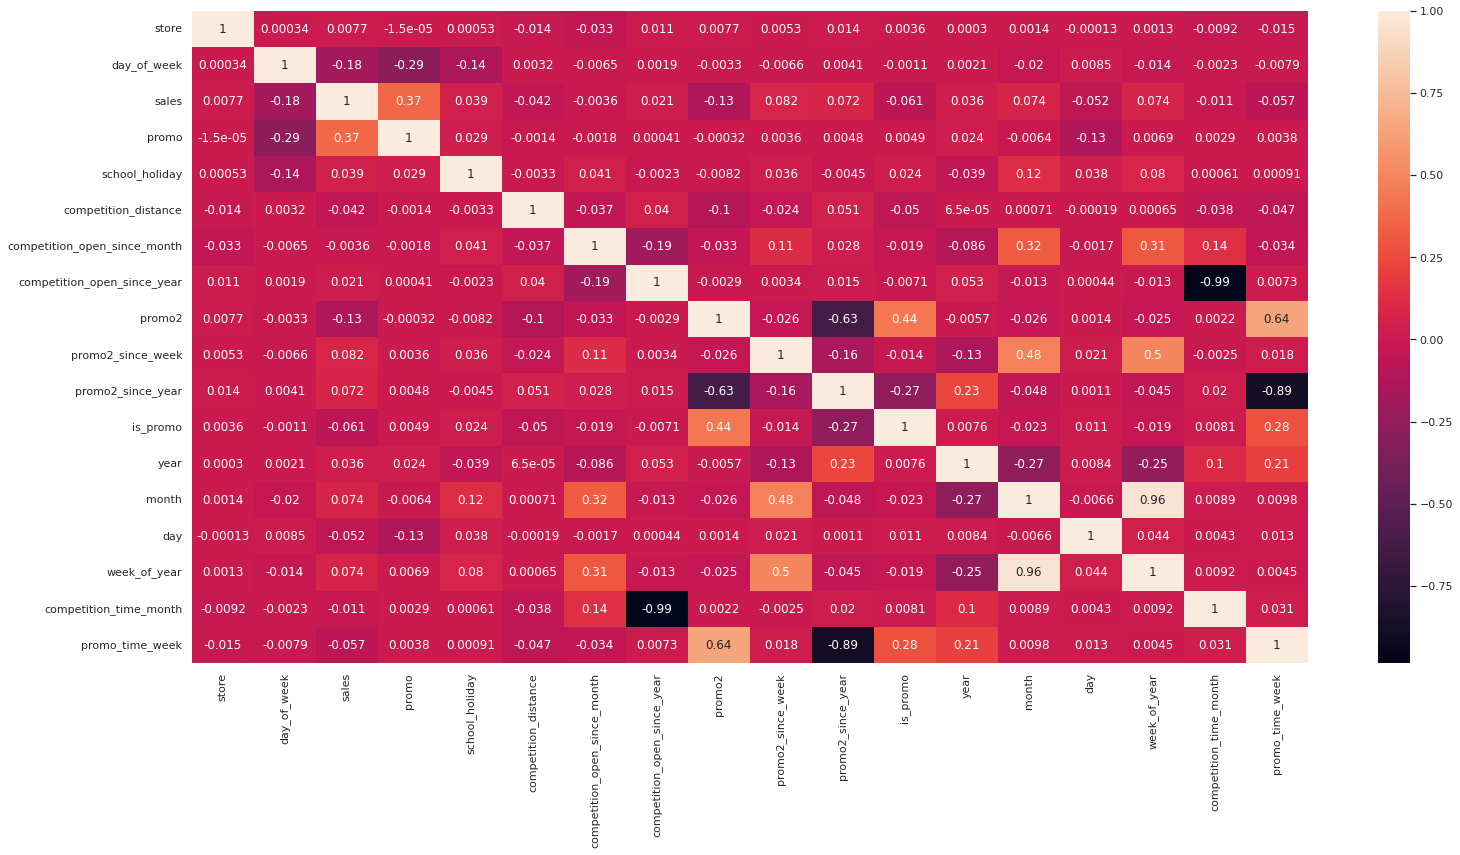

In [57]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(25,12))
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical attributes
In this step, I will use the Cramer's V method to calculate the correlation between categorical variables.

In [58]:
# categorical attributes refer to columns of type 'object'
a = df4.select_dtypes( include  = 'object')


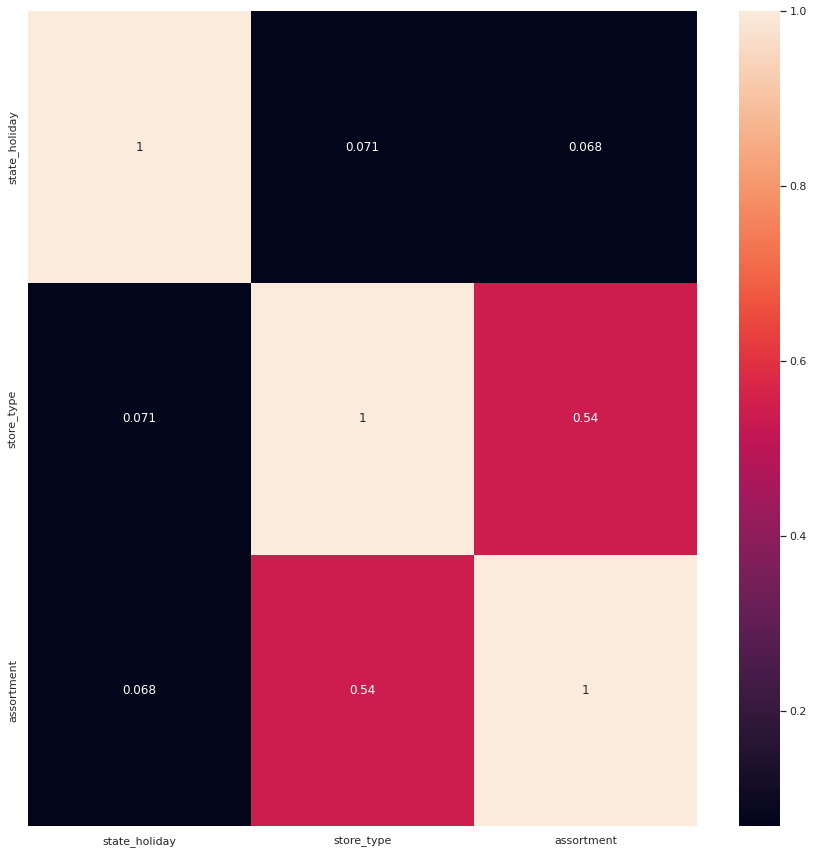

In [59]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#  final dataset
d = pd.DataFrame({'state_holiday':[a1,a2,a3],
                  'store_type':[a4,a5,a6],
                  'assortment':[a7,a8,a9] })

d = d.set_index(d.columns)
sns.heatmap(d,annot=True);


# 5.0. DATA PREPARATION

In [60]:
df5 = df4.copy()

## 5.1. Normalization

Normallization is a method of scaling applied to variables presenting a normal distribution. After consulting section 4.1.2 it is noted that there is no normal distribution. Therefore, normalization (which would be centered on 0 and adjust the standard deviation to 1) will not be applied to any data series.

## 5.2. Rescaling

In [61]:
# converting the 'week_of_year' series from type UInt32 to int64
df5['week_of_year'] = df5['week_of_year'].astype('int64')

The 4 variables that rescaling will be applied are:

   - 'competition_distance'
   
   - 'year'
   
   - 'competition_time_month'
   
   - 'promo_time_week'

MinMaxScaler will transform each value in the column proportionally within the range [0,1]. RobustScalers is used to minimize the influence of outliers.

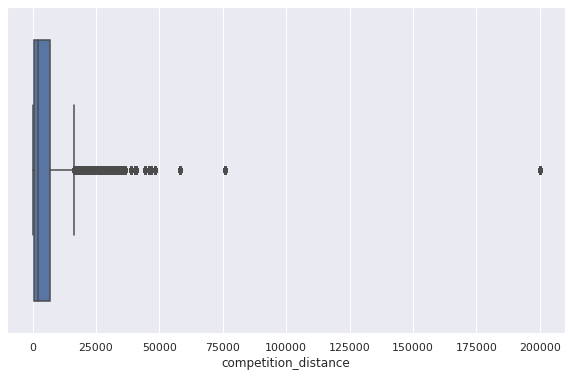

In [62]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['competition_distance']);

Competition distance has outliers resulted from filling up the data missing. RobustScaler will be used to rescale this variable.

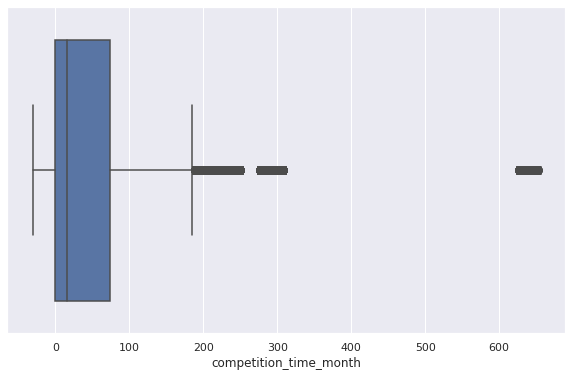

In [63]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['competition_time_month']);

The same analysis applies to competition time month. RobustScaler will be used to rescale this variable.


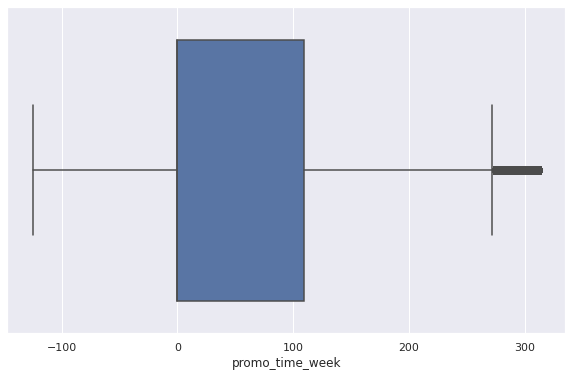

In [64]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['promo_time_week']);

promo time week does not have outliers. In this case, MinMaxScaler will be applied.

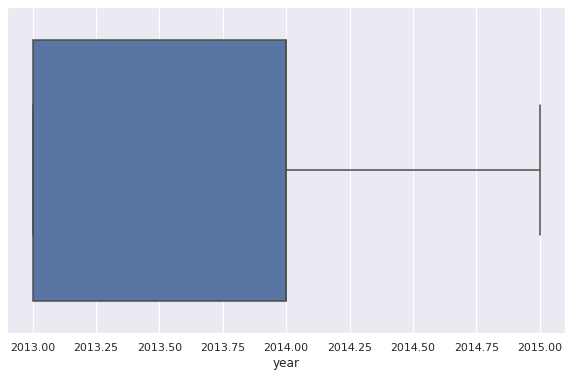

In [65]:
plt.figure(figsize=(10,6))
sns.boxplot(x = df5['year']);

In [66]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump( mms, open('parameter/promo_time_week_scaler.pkl','wb') )

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )


## 5.3. Transformation

### 5.3.1. Non-cyclical features encoding


In [67]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Cyclical features encoding

In [68]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x : np.sin(x * (2 * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x : np.cos(x * (2 * np.pi / 7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x : np.sin(x * (2 * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x : np.cos(x * (2 * np.pi / 52)))

In [69]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.285388,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922374,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801370,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.285388,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.285388,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


### 5.3.3. Transformation of the target variable


In [70]:
df5['sales'] = np.log1p( df5['sales'])

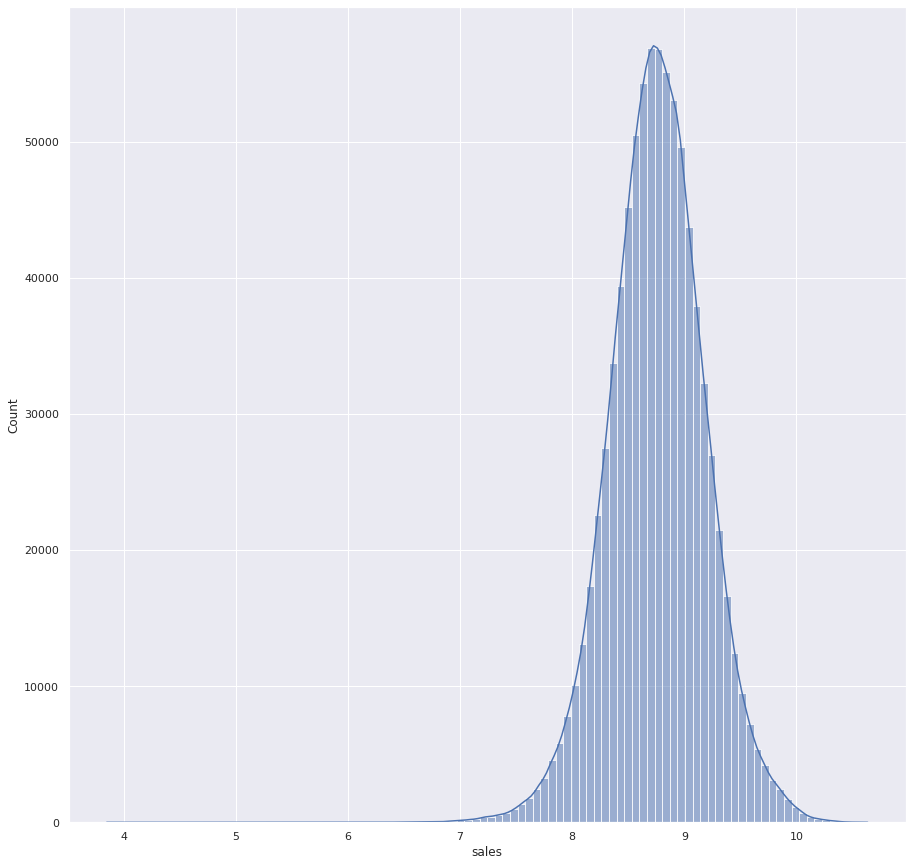

In [71]:
sns.histplot(x = df5['sales'],bins=100,kde = True);

# 6.0. FEATURE SELECTION

"Feature selection is the process of reducing the number of input variables when developing a predictive model.

It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model." - by Jason Brownlee on November 27, 2019 in Data Preparation

Keep it simple.

In [72]:
df6 = df5.copy()
# delete features that were already used to create others but are now no longer important
cols_drop = ['week_of_year','day','month','day_of_week', 'promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis = 1)

## 6.1 Split dataframe into training and test dataset 

In [73]:
df6.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.285388,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,1.054054,0.922374,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,1.202703,0.801370,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.285388,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,-0.162162,0.285388,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [74]:
df6[['store','date']].groupby('store').min().reset_index()['date'][0]

Timestamp('2013-01-02 00:00:00')

In [75]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0]

Timestamp('2015-07-31 00:00:00')

In [76]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days = 6*7 )

Timestamp('2015-06-19 00:00:00')

In [77]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']


print("Training min date: {}".format(X_train['date'].min()))
print("Training max date: {}".format(X_train['date'].max()))

print(f"\nTest min date: {X_test['date'].min()}")
print(f"Test max date: {X_test['date'].max()}")

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

Wrapper Method 

In [78]:
# # training and test dataset for Boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )

# # define Boruta (random forest model to select the features)
# # we need to pass a array of numbers to Boruta, not a dataframe
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )

# # After running Boruta
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # columns not selected 
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )

After running Boruta as Feature Selector and reducing some input variables, I will comment the section 6.2.

## 6.3. Manual Feature Selection

In [79]:
cols_not_selected_boruta = [
    'is_promo',
    'month_sin', 
    'school_holiday', 
    'state_holiday_christmas', 
    'state_holiday_easter_holiday',                            
    'state_holiday_public_holiday', 
    'state_holiday_regular_day', 
    'week_of_year_sin', 
    'year']

# add 'month_sin' and 'week_of_year_sin' (initially Boruta left both out)

cols_selected_boruta = [
    'store',
    'promo', 
    'store_type', 
    'assortment', 
    'competition_distance', 
    'competition_open_since_month',
    'competition_open_since_year', 
    'promo2', 
    'promo2_since_week', 
    'promo2_since_year', 
    'competition_time_month',
    'promo_time_week', 
    'month_cos',
    'month_sin',
    'day_sin', 
    'day_cos', 
    'week_of_year_cos', 
    'day_of_week_sin', 
    'day_of_week_cos',
    'week_of_year_sin']

# columns to add
feat_to_add = ['sales','date']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. MACHINE LEARNING MODELLING

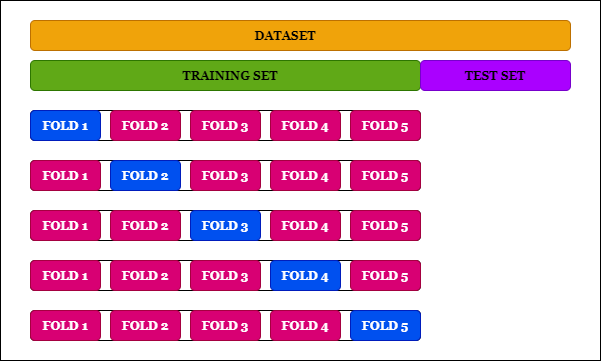

In [89]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Cross-Validation
x_training = X_train[ cols_selected_boruta_full]

# Image Reference: Siladittya Manna - Mar 20, 2020
Image('Images/cross_validation.png')


## 7.1. Average Model


In [81]:
aux1 = x_train.copy()
aux1['sales'] = y_train.copy()

aux2 = x_test.copy()

# prediction
aux3 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux2 = pd.merge( aux2, aux3, how='left', on='store' )

aux2.set_index('store',inplace=True)
yhat_baseline = aux2['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1429.763326,0.216814,1939.32873


## 7.2. Linear Regression Model

In [82]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1868.139303,0.292823,2672.866075


The Average Model had a better performance than the Linear Regression Model. This indicates that the dataset is complex enough and requires other machine learning algorithms.

### 7.2.1. Linear Regression Model - Cross Validation

In [90]:
# lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
# lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2082.69 +/- 294.85,0.3 +/- 0.02,2953.48 +/- 467.23


## 7.3. Regularized Linear Regression Model

In [83]:
# model
lrr = Lasso( alpha=0.01 ).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1892.079431,0.289163,2744.769195


### 7.3.1. Lasso - Cross Validation

In [91]:
# lrr_result_cv = cross_validation( x_training, 5, 'Linear Regression - Lasso', lrr, verbose=False )
# lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2116.16 +/- 340.55,0.29 +/- 0.01,3057.36 +/- 503.47


## 7.4. Random Forest Regressor

In [84]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42, max_depth=10 ).fit(x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,1583.659183,0.23486,2273.98109


### 7.4.1. Random Forest Regressor - Cross Validation

In [92]:
# rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
# rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,1752.72 +/- 247.1,0.24 +/- 0.01,2477.31 +/- 347.8


## 7.5. XGBoost Regressor

In [85]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

model_xgb = xgb.XGBRegressor( max_depth=10).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb))
xgb_result

[11:15:02] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,706.859002,0.101647,1023.581325


### 7.5.1. XGBoost Regressor - Cross Validation

In [93]:
# xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
# xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,952.58 +/- 216.31,0.13 +/- 0.02,1379.32 +/- 309.63


## 7.6. Compare Model’s Performance

### 7.6.1. Single Performance 

In [86]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result,rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,706.859002,0.101647,1023.581325
0,Average Model,1429.763326,0.216814,1939.328730
0,Random Forest Regressor,1583.659183,0.234860,2273.981090
0,Linear Regression,1868.139303,0.292823,2672.866075
0,Linear Regression - Lasso,1892.079431,0.289163,2744.769195


The table above indicates that the XGBoos Regressor is the best model between all the models applied after comparing the errors. However; we evaluated the model only for the last 6 weeks. The ML model needs to be evaluated on other parts of the dataframe. The method used is called cross-validation, providing a more reliable overview of the performance of the models.

### 7.6.2. Real Performance - Cross Validation

In [94]:
modelling_result_cv = pd.concat( [ lr_result_cv, lrr_result_cv ,rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,952.58 +/- 216.31,0.13 +/- 0.02,1379.32 +/- 309.63
0,Random Forest Regressor,1752.72 +/- 247.1,0.24 +/- 0.01,2477.31 +/- 347.8
0,Linear Regression,2082.69 +/- 294.85,0.3 +/- 0.02,2953.48 +/- 467.23
0,Linear Regression - Lasso,2116.16 +/- 340.55,0.29 +/- 0.01,3057.36 +/- 503.47


XGBoost Regressor will be used to predict the sales as this model presented the best better performance. XGBoost does not require a large amount of space on the server in deploy step, reducing company's cost.

# 8.0. HYPERPARAMETER FINE TUNING

Technique used to maximize the model performance. 
The 3 main hyperparameter adjustment strategies are: 

- Random search 
- Grid search
- Bayesian search



## 8.1. Random Search

In [95]:
# param = {
#         'n_estimators': [100, 150, 200, 250, 300], 
#         'eta': [0.01, 0.03],
#         'max_depth': [3, 5, 9],
#         'subsample': [0.1, 0.5, 0.7],
#         'colsample_bytree': [0.3, 0.7, 0.9],
#         'min_child_weight': [3, 8, 15]
#         }

# MAX_EVAL = 5

In [96]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     # escolha os valores dos parâmetros aleatoriamente
#     hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
#     print(hp)

#     # model
#     model_xgb = xgb.XGBRegressor(
#                                 objective='reg:squarederror',
#                                 n_estimators=hp['n_estimators'],
#                                 eta=hp['eta'],
#                                 max_depth=hp['max_depth'],
#                                 subsample=hp['subsample'],
#                                 colsample_bytree=hp['colsample_bytree'],
#                                 min_child_weight=hp['min_child_weight']
#                                 )

#     # performance
#     result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb)
#     final_result = pd.concat([final_result, result])

# final_result

{'n_estimators': 100, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 250, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 100, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 200, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 100, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 15}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,3013.62 +/- 398.57,0.36 +/- 0.02,3989.84 +/- 507.38
0,XGBoost Regressor,4029.73 +/- 431.62,0.49 +/- 0.01,4883.39 +/- 535.94
0,XGBoost Regressor,7050.29 +/- 589.75,0.95 +/- 0.0,7717.77 +/- 690.29
0,XGBoost Regressor,5240.35 +/- 542.94,0.67 +/- 0.01,6062.87 +/- 649.89
0,XGBoost Regressor,7051.31 +/- 591.01,0.95 +/- 0.0,7721.54 +/- 691.34


## 8.2. Final Model

In [97]:
# # Pass the best parameters found out by Random Search
# param_tuned = {
#         'n_estimators': 1000, 
#         'eta': 0.03,
#         'max_depth': 9,
#         'subsample': 0.7,
#         'colsample_bytree': 0.9,
#         'min_child_weight': 15
#         }

In [98]:
# # model
# model_xgb_tuned = xgb.XGBRegressor(
#                             objective='reg:squarederror',
#                             n_estimators=param_tuned['n_estimators'],
#                             eta=param_tuned['eta'],
#                             max_depth=param_tuned['max_depth'],
#                             subsample=param_tuned['subsample'],
#                             colsample_bytree=param_tuned['colsample_bytree'],
#                             min_child_weight=param_tuned['min_child_weight']
#                             ).fit(x_train, y_train)

# # prediction
# yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# # performance
# result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
# result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,665.307731,0.097244,973.681265


## 8.2. Saving the Final Model

In [99]:
# # saving so I do not need to train the model again
# pickle.dump(model_xgb_tuned, open('/home/rafael/Repos/rossmann_sales_prediction/model/model_rossmann.pkl', 'wb'))

In [100]:
# to load the template
model_xgb_tuned = pickle.load(open('/home/rafael/Repos/rossmann_sales_prediction/model/model_rossmann.pkl', 'rb'))

yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

xgb_result_tuned = ml_error('XGBoost regressor',np.expm1(y_test),np.expm1(yhat_xgb_tuned) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost regressor,665.307731,0.097244,973.681265


In [101]:
mpe = mean_percentage_error( np.expm1 (y_test), np.expm1( yhat_xgb_tuned))
mpe
# negative mpe means the model is overastimating the sales predictions

-0.0020735448522517406

# 9.0. PERFORMANCE

In [102]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [103]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

In [104]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106622.695312,103203.960578,110041.430047,3418.734735,0.590538
908,909,234667.687500,227094.466224,242240.908776,7573.221276,0.509147
875,876,203494.718750,199521.466691,207467.970809,3973.252059,0.304469
273,274,192832.375000,191424.476710,194240.273290,1407.898290,0.241474
687,688,156538.031250,155796.892958,157279.169542,741.138292,0.230893


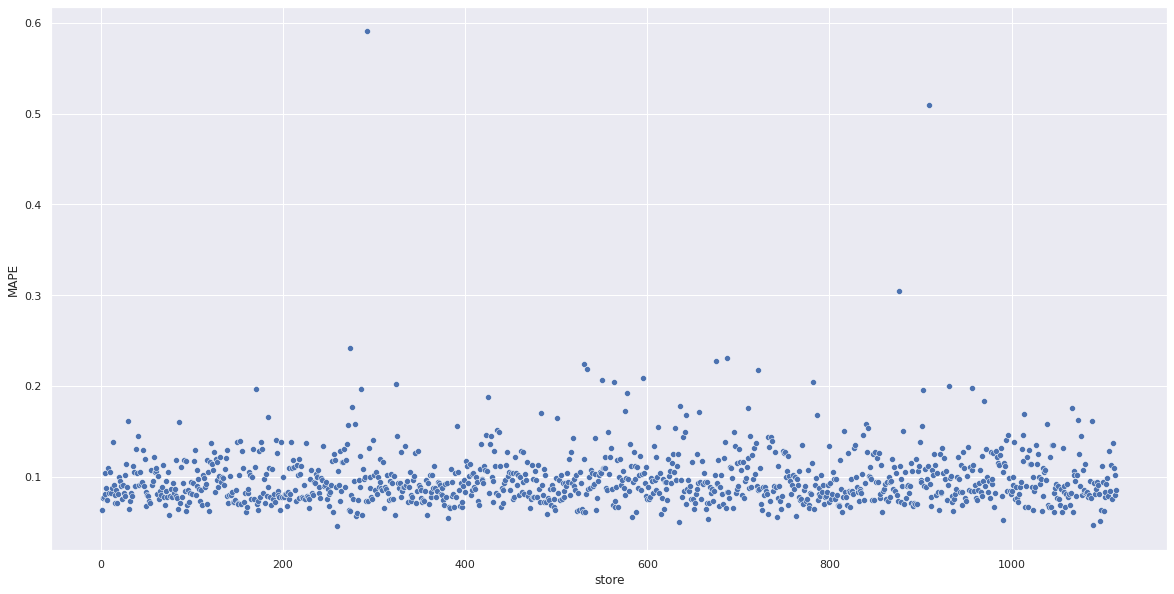

In [119]:
plt.figure(figsize = (20,10))
sns.scatterplot(x='store', y='MAPE', data=df92);

## 9.2. Total Performance

In [106]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0: 'Values'} )
df93['Values'] = df93['Values'].map( '${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"$283,822,208.00"
1,worst_scenario,"$283,077,020.19"
2,best_scenario,"$284,567,399.03"


## 9.3. Machine Learning Performance


In [110]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

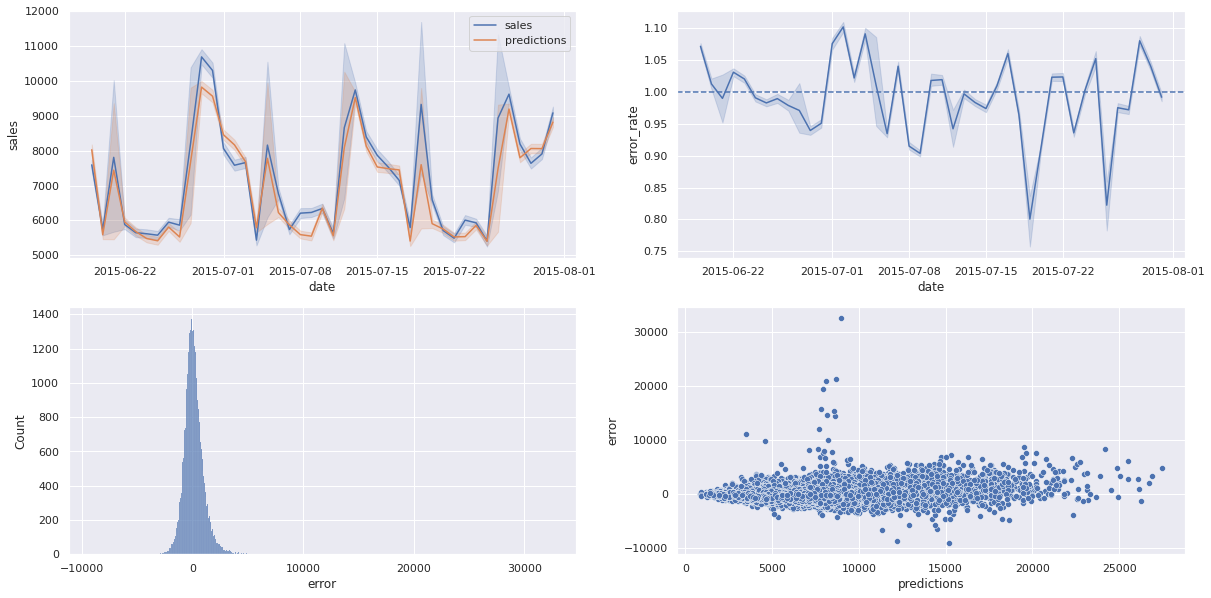

In [120]:
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'sales')
sns.lineplot(x = 'date', y = 'predictions', data = df9, label = 'predictions')

plt.subplot(2,2,2)
sns.lineplot(x = 'date', y = 'error_rate', data = df9)
plt.axhline(1, linestyle = '--')

plt.subplot(2,2,3)
sns.histplot(data = df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(x = df9['predictions'], y = df9['error']);


# 10.0. DEPLOY MODEL TO PRODUCTION

## 10.1. Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path = '/home/rafael/Repos/rossmann_sales_prediction/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )


    def data_cleaning( self, df1 ):
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        
        # rename
        df1.columns = cols_new
        
        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )
        
        ## 1.5. Fillout NA
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)


        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month 
                                                if math.isnan(x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis = 1)
        
        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year 
                                                if math.isnan(x['competition_open_since_year'])
                                                else x['competition_open_since_year'], axis = 1)

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week 
                                     if math.isnan(x['promo2_since_week'])
                                     else x['promo2_since_week'], axis = 1)

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year 
                                     if math.isnan(x['promo2_since_year'])
                                     else x['promo2_since_year'], axis = 1)

        #promo_interval
        month_map = {1: 'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 
                                                                              1 if x['month_map'] in x['promo_interval'].split(',') else
                                                                              0, axis = 1 )

        ## 1.6. Change Data Types

        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

        
        return df1
    
    
    def feature_engineering( self, df2 ):
        
        # year
        df2 ['year'] = df2['date'].dt.year

        # month
        df2 ['month'] = df2['date'].dt.month

        # day
        df2 ['day'] = df2['date'].dt.day

        # week of year
        df2 ['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2 ['year_week'] = df2['date'].dt.strftime('%Y-%W')


        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply( lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' 
                                                          else 'easter_holiday' if  x=='b'  
                                                          else 'christmas' if x == 'c'
                                                          else 'regular_day')
        
       
        # Filtering  Variables
        
        # df3 = df3.loc[df3['open'] == 1]
        df2 = df2[(df2['open'] != 0)]
        
        cols_drop = ['open','promo_interval','month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    def data_preparation( self, df5 ):
    
        # converting the 'week_of_year' series from type UInt32 to int64
        df5['week_of_year'] = df5['week_of_year'].astype('int64')


        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.transform(df5[['year']].values)


        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding

        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'])


        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,
                           'extra': 2,
                           'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)


        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x : np.sin(x * (2 * np.pi / 7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x : np.cos(x * (2 * np.pi / 7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x : np.sin(x * (2 * np.pi / 52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x : np.cos(x * (2 * np.pi / 52)))

        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 
                                'competition_open_since_month','competition_open_since_year', 'promo2', 
                                'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                                'promo_time_week', 'month_cos','month_sin','day_sin', 'day_cos', 
                                'week_of_year_cos', 'day_of_week_sin', 'day_of_week_cos','week_of_year_sin']
        
        return df5 [cols_selected]

    def get_prediction ( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )

        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )

        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/home/rafael/Repos/rossmann_sales_prediction/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )
@app.route( '/rossmann/predict', methods=['POST'] )
                          
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
            
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
            
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
            
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
            
        # data preparation
        df3 = pipeline.data_preparation( df2 )
            
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
            
        return df_response
        
        
    else:
        
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' ) # '0.0.0.0' indicates that this Flask application is running locally so I can run the simulation.

## 10.3. API Tester

In [ ]:
import requests
import json

In [ ]:
# loading test dataset
df10 = pd.read_csv( '/home/rafael/Repos/rossmann_sales_prediction/rossmann-store-sales/test.csv' )

In [ ]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [ 38, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [ ]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
# url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-modelprediction-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
d1 = pd.DataFrame( r.json(), columns = r.json()[0].keys())

In [ ]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( d2.loc[i, 'store'], d2.loc[i, 'prediction'] ) )